Update: Study the relation between classification accuracy and quantity of labeled and unlabeled documents.

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
from Semi_EM_NB import Semi_EM_MultinomialNB


from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [11]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [16]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_accuracies= list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        train_accuracies.append(metrics.accuracy_score(valid_y, pred))
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % np.mean(np.array(train_accuracies)))
    return train_accuracies, train_time

In [30]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud().generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [9]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:    15076	Test set size:     3770


In [12]:
# preprocess train and test text data
train_X_clean = map(remove_noise, train_X)
test_X_clean = map(remove_noise, test_X)

In [13]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X_clean)
test_vec = vectorizer.transform(test_X_clean)
print train_vec.shape, test_vec.shape

(15076, 13318) (3770, 13318)


In [15]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.1 # labeled vs total(labeled+unlabeled)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y)
print X_l.shape, X_u.shape

(1507, 13318) (13569, 13318)


In [17]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_clf = MultinomialNB(alpha=1e-2)
cross_validation(nb_clf, X_l, y_l)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.092 seconds
Average training accuracy: 0.611


([0.6143790849673203,
  0.61764705882352944,
  0.63815789473684215,
  0.58333333333333337,
  0.60137457044673537],
 0.09226512908935547)

In [18]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2) # semi supervised EM based Naive Bayes classifier
cross_validation(em_nb_clf, X_l, y_l, X_u)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Initial expected log likelihood = -6083120.203

EM iteration #1
	Expected log likelihood = -5599479.783
EM iteration #2
	Expected log likelihood = -5592539.888
EM iteration #3
	Expected log likelihood = -5591145.943
EM iteration #4
	Expected log likelihood = -5590972.413
EM iteration #5
	Expected log likelihood = -5590924.138
EM iteration #6
	Expected log likelihood = -5590897.762
EM iteration #7
	Expected log likelihood = -5590897.762
Fold # 2
Initial expected log likelihood = -6088705.799

EM iteration #1
	Expected log likelihood = -5599145.874
EM iteration #2
	Expected log likelihood = -5592642.415
EM iteration #3
	Expected log likelihood = -5591526.484
EM iteration #4
	Expected log likelihood = -5591201.453
EM iteration #5
	Expected log likelihood = -5591069.501
EM iteration #6
	Expected log likelihood = -5590995.817
EM iteration #7
	Expected log likelihood = -5590948.682
EM iteration #8
	Expected log

([0.66013071895424835,
  0.66339869281045749,
  0.67434210526315785,
  0.62666666666666671,
  0.6872852233676976],
 237.23534107208252)

In [20]:
# Evaluate original NB classifier using test data set
nb_clf = MultinomialNB(alpha=1e-2).fit(X_l, y_l)
pred = nb_clf.predict(test_vec)
print(metrics.classification_report(test_y, pred, target_names=category_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_y, pred))

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.43      0.46       160
           comp.graphics       0.53      0.58      0.56       195
 comp.os.ms-windows.misc       0.62      0.48      0.54       197
comp.sys.ibm.pc.hardware       0.57      0.62      0.60       196
   comp.sys.mac.hardware       0.58      0.58      0.58       193
          comp.windows.x       0.68      0.77      0.73       198
            misc.forsale       0.71      0.59      0.64       195
               rec.autos       0.67      0.59      0.62       198
         rec.motorcycles       0.46      0.62      0.53       199
      rec.sport.baseball       0.87      0.83      0.85       199
        rec.sport.hockey       0.88      0.81      0.84       200
               sci.crypt       0.74      0.77      0.75       198
         sci.electronics       0.61      0.53      0.57       197
                 sci.med       0.75      0.74      0.74       198
         

In [21]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2).fit(X_l, y_l, X_u)
pred = em_nb_clf.predict(test_vec)
print(metrics.classification_report(test_y, pred, target_names=category_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_y, pred))

Initial expected log likelihood = -6039292.395

EM iteration #1
	Expected log likelihood = -5596639.522
EM iteration #2
	Expected log likelihood = -5590658.925
EM iteration #3
	Expected log likelihood = -5589834.717
EM iteration #4
	Expected log likelihood = -5589566.999
EM iteration #5
	Expected log likelihood = -5589154.362
EM iteration #6
	Expected log likelihood = -5588877.181
EM iteration #7
	Expected log likelihood = -5588525.711
EM iteration #8
	Expected log likelihood = -5588512.514
EM iteration #9
	Expected log likelihood = -5588510.481
EM iteration #10
	Expected log likelihood = -5588510.481
                          precision    recall  f1-score   support

             alt.atheism       0.58      0.42      0.49       160
           comp.graphics       0.52      0.70      0.60       195
 comp.os.ms-windows.misc       0.71      0.38      0.50       197
comp.sys.ibm.pc.hardware       0.53      0.67      0.59       196
   comp.sys.mac.hardware       0.67      0.70      0.69     

alt.atheism: post peopl ani atheist religion think say wa thi god
comp.graphics: vesa gif convert vga thank ani imag program file graphic
comp.os.ms-windows.misc: ati thi use ini driver font problem card file window
comp.sys.ibm.pc.hardware: drive ani problem chip pc card thi scsi dx bu
comp.sys.mac.hardware: anyon extern work drive use simm board thi appl mac
comp.windows.x: know ncd applic thi hi thank ani use server window
misc.forsale: drive ask offer price includ new sale ship mail sell
rec.autos: wagon thank ha make toyota like wa ani thi car
rec.motorcycles: cop question thi biker dod helmet wa dog ride bike
rec.sport.baseball: sox stat year leagu player win wa basebal team game
rec.sport.hockey: pt stat nhl season team hockey wa play player game
sci.crypt: make escrow den chip use secur thi clipper encrypt key
sci.electronics: batteri doe grind chip anyon voltag wire use thi circuit
sci.med: ha effect use drug medic food wa veri thi doctor
sci.space: station nasa earth sky like

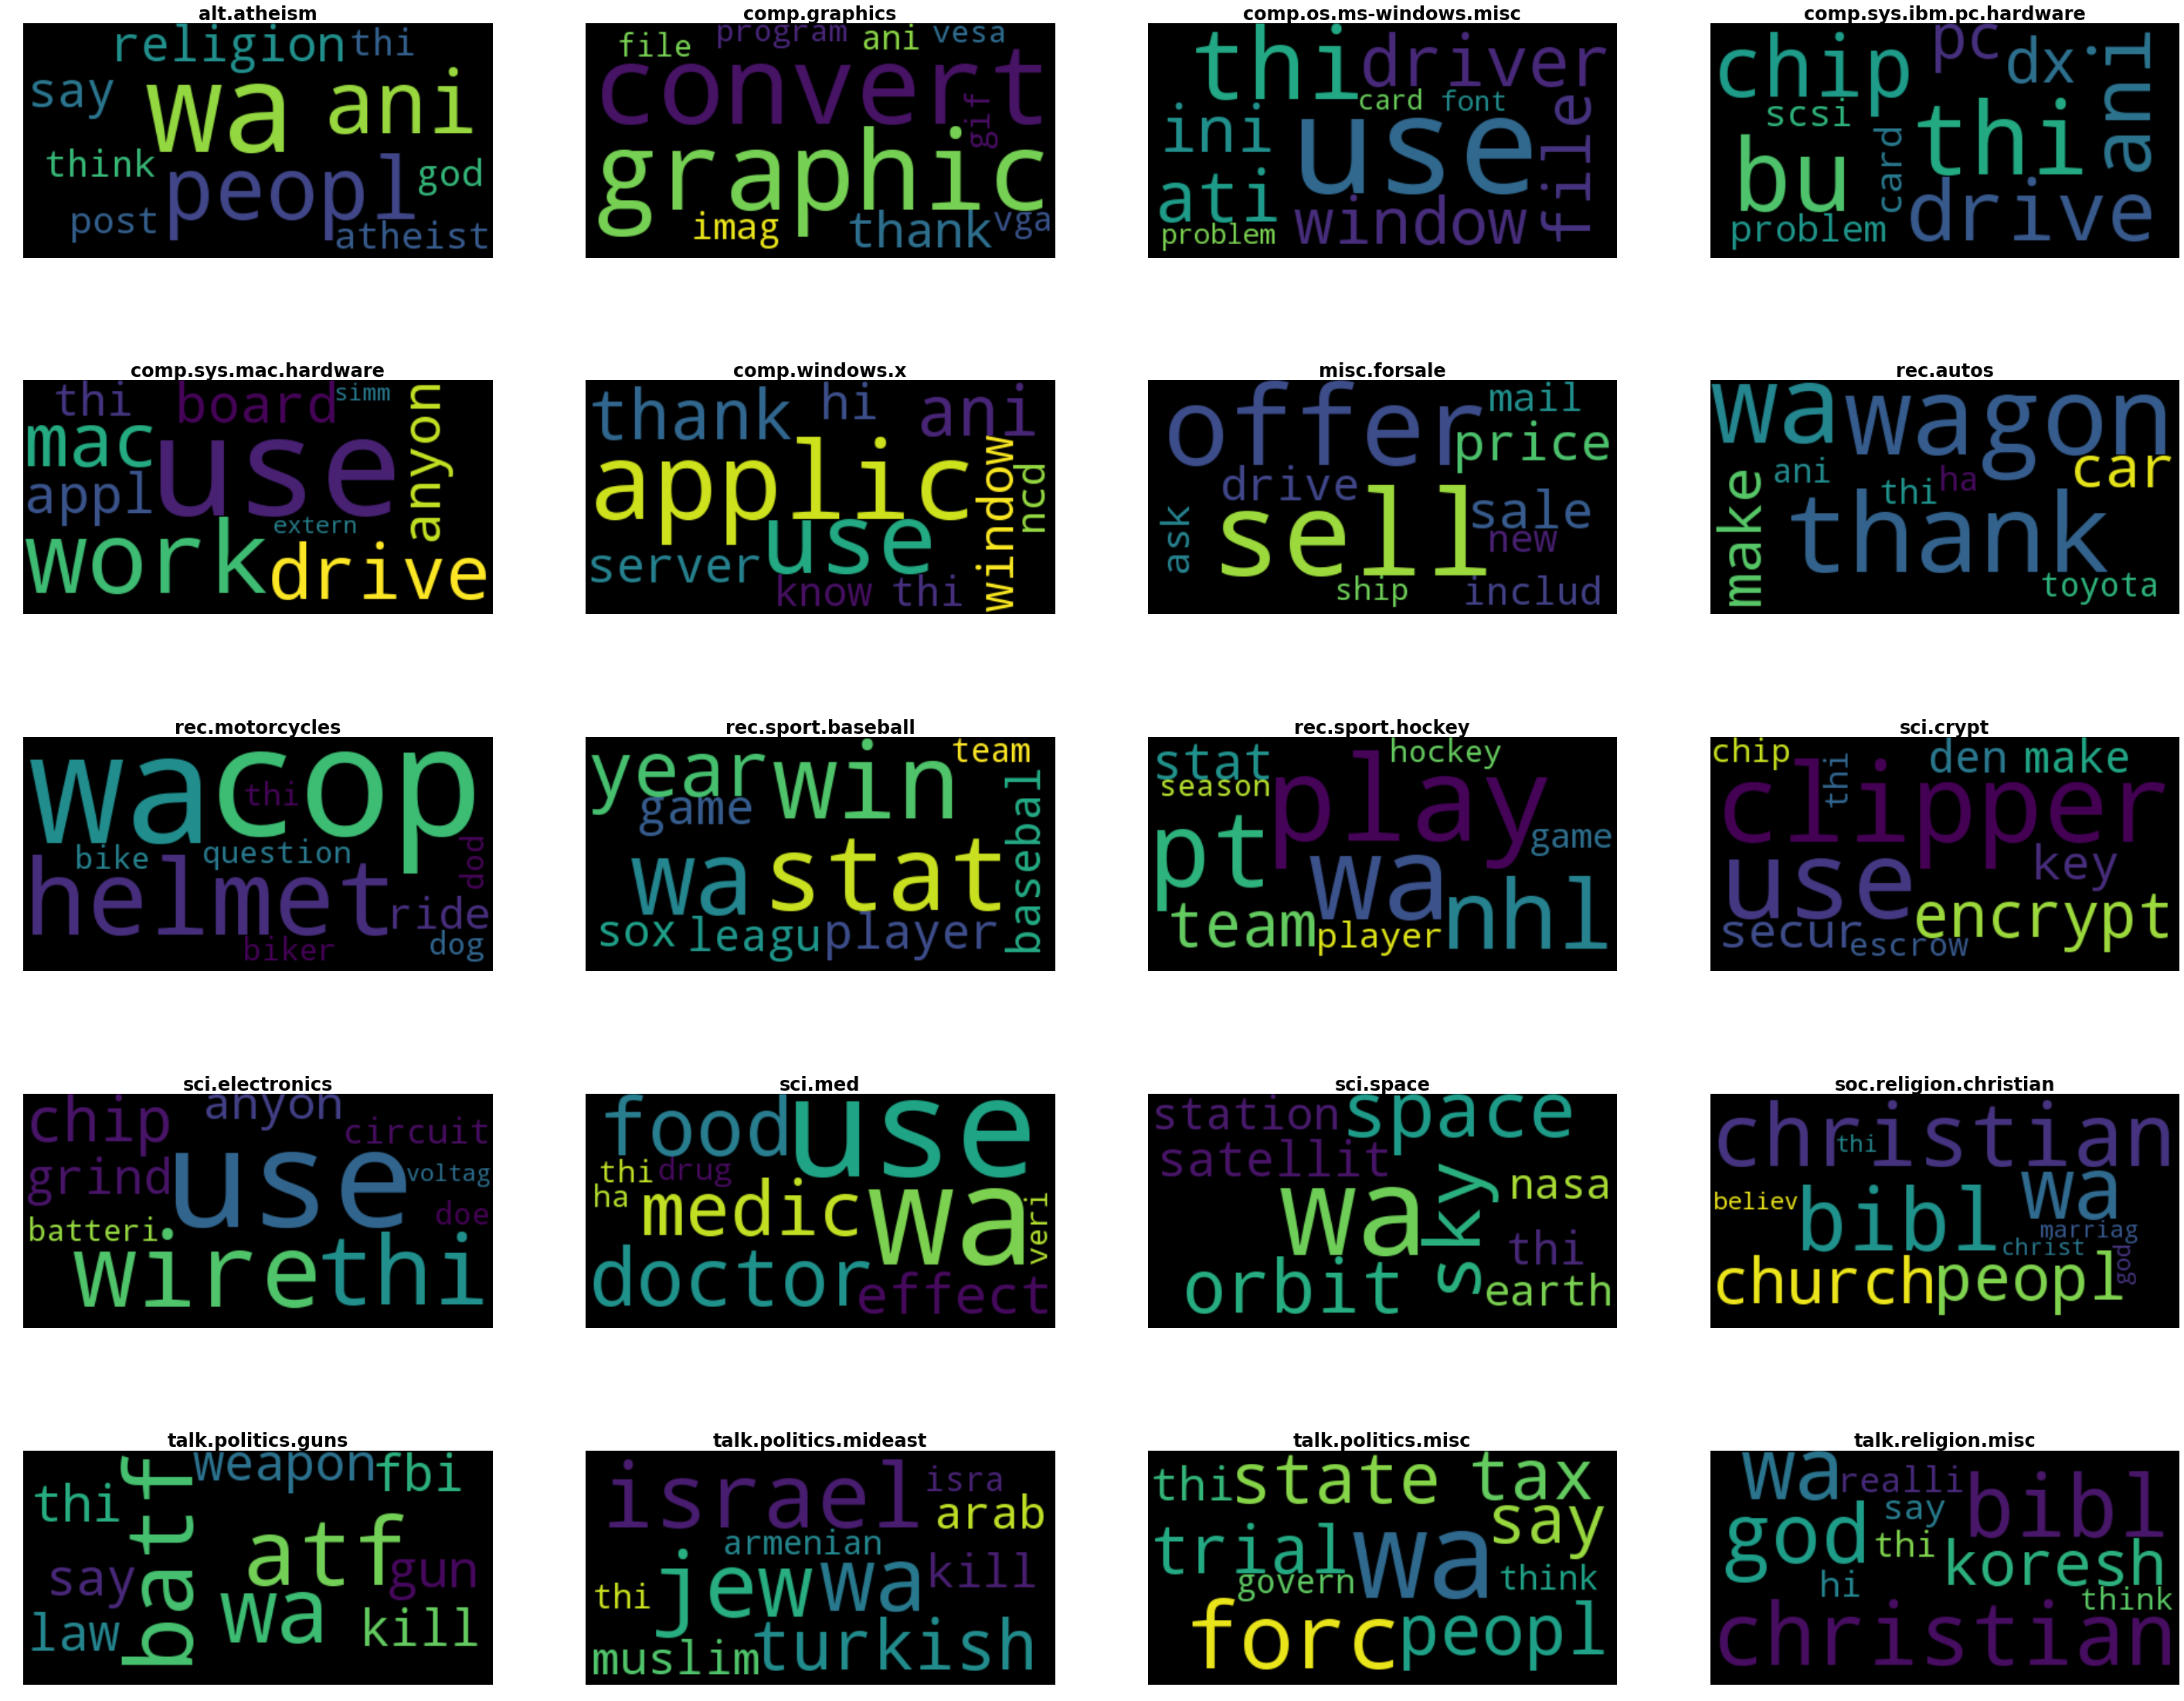

In [31]:
show_topK(nb_clf, vectorizer, category_names, K=10) # keywords for each class by original NB classifier

alt.atheism: wa religion peopl delet think atheist moral say god thi
comp.graphics: use pleas format ani program thi thank imag graphic file
comp.os.ms-windows.misc: program thank problem thi version use font driver file window
comp.sys.ibm.pc.hardware: ide dx ani use bu thank thi scsi card drive
comp.sys.mac.hardware: work simm problem card use thi drive monitor appl mac
comp.windows.x: ani widget program motif run file server thi use window
misc.forsale: new mail condit pleas includ price ship sell offer sale
rec.autos: buy drive mile ford new ani thi engin wa car
rec.motorcycles: helmet like dog dod car motorcycl thi wa ride bike
rec.sport.baseball: player pitcher hi basebal hit team year pitch wa game
rec.sport.hockey: nhl season thi playoff player play hockey wa team game
sci.crypt: escrow phone govern secur use clipper chip thi encrypt key
sci.electronics: work ani wire electron line power batteri circuit thi use
sci.med: drug diseas know ha medic effect patient doctor wa thi
sci

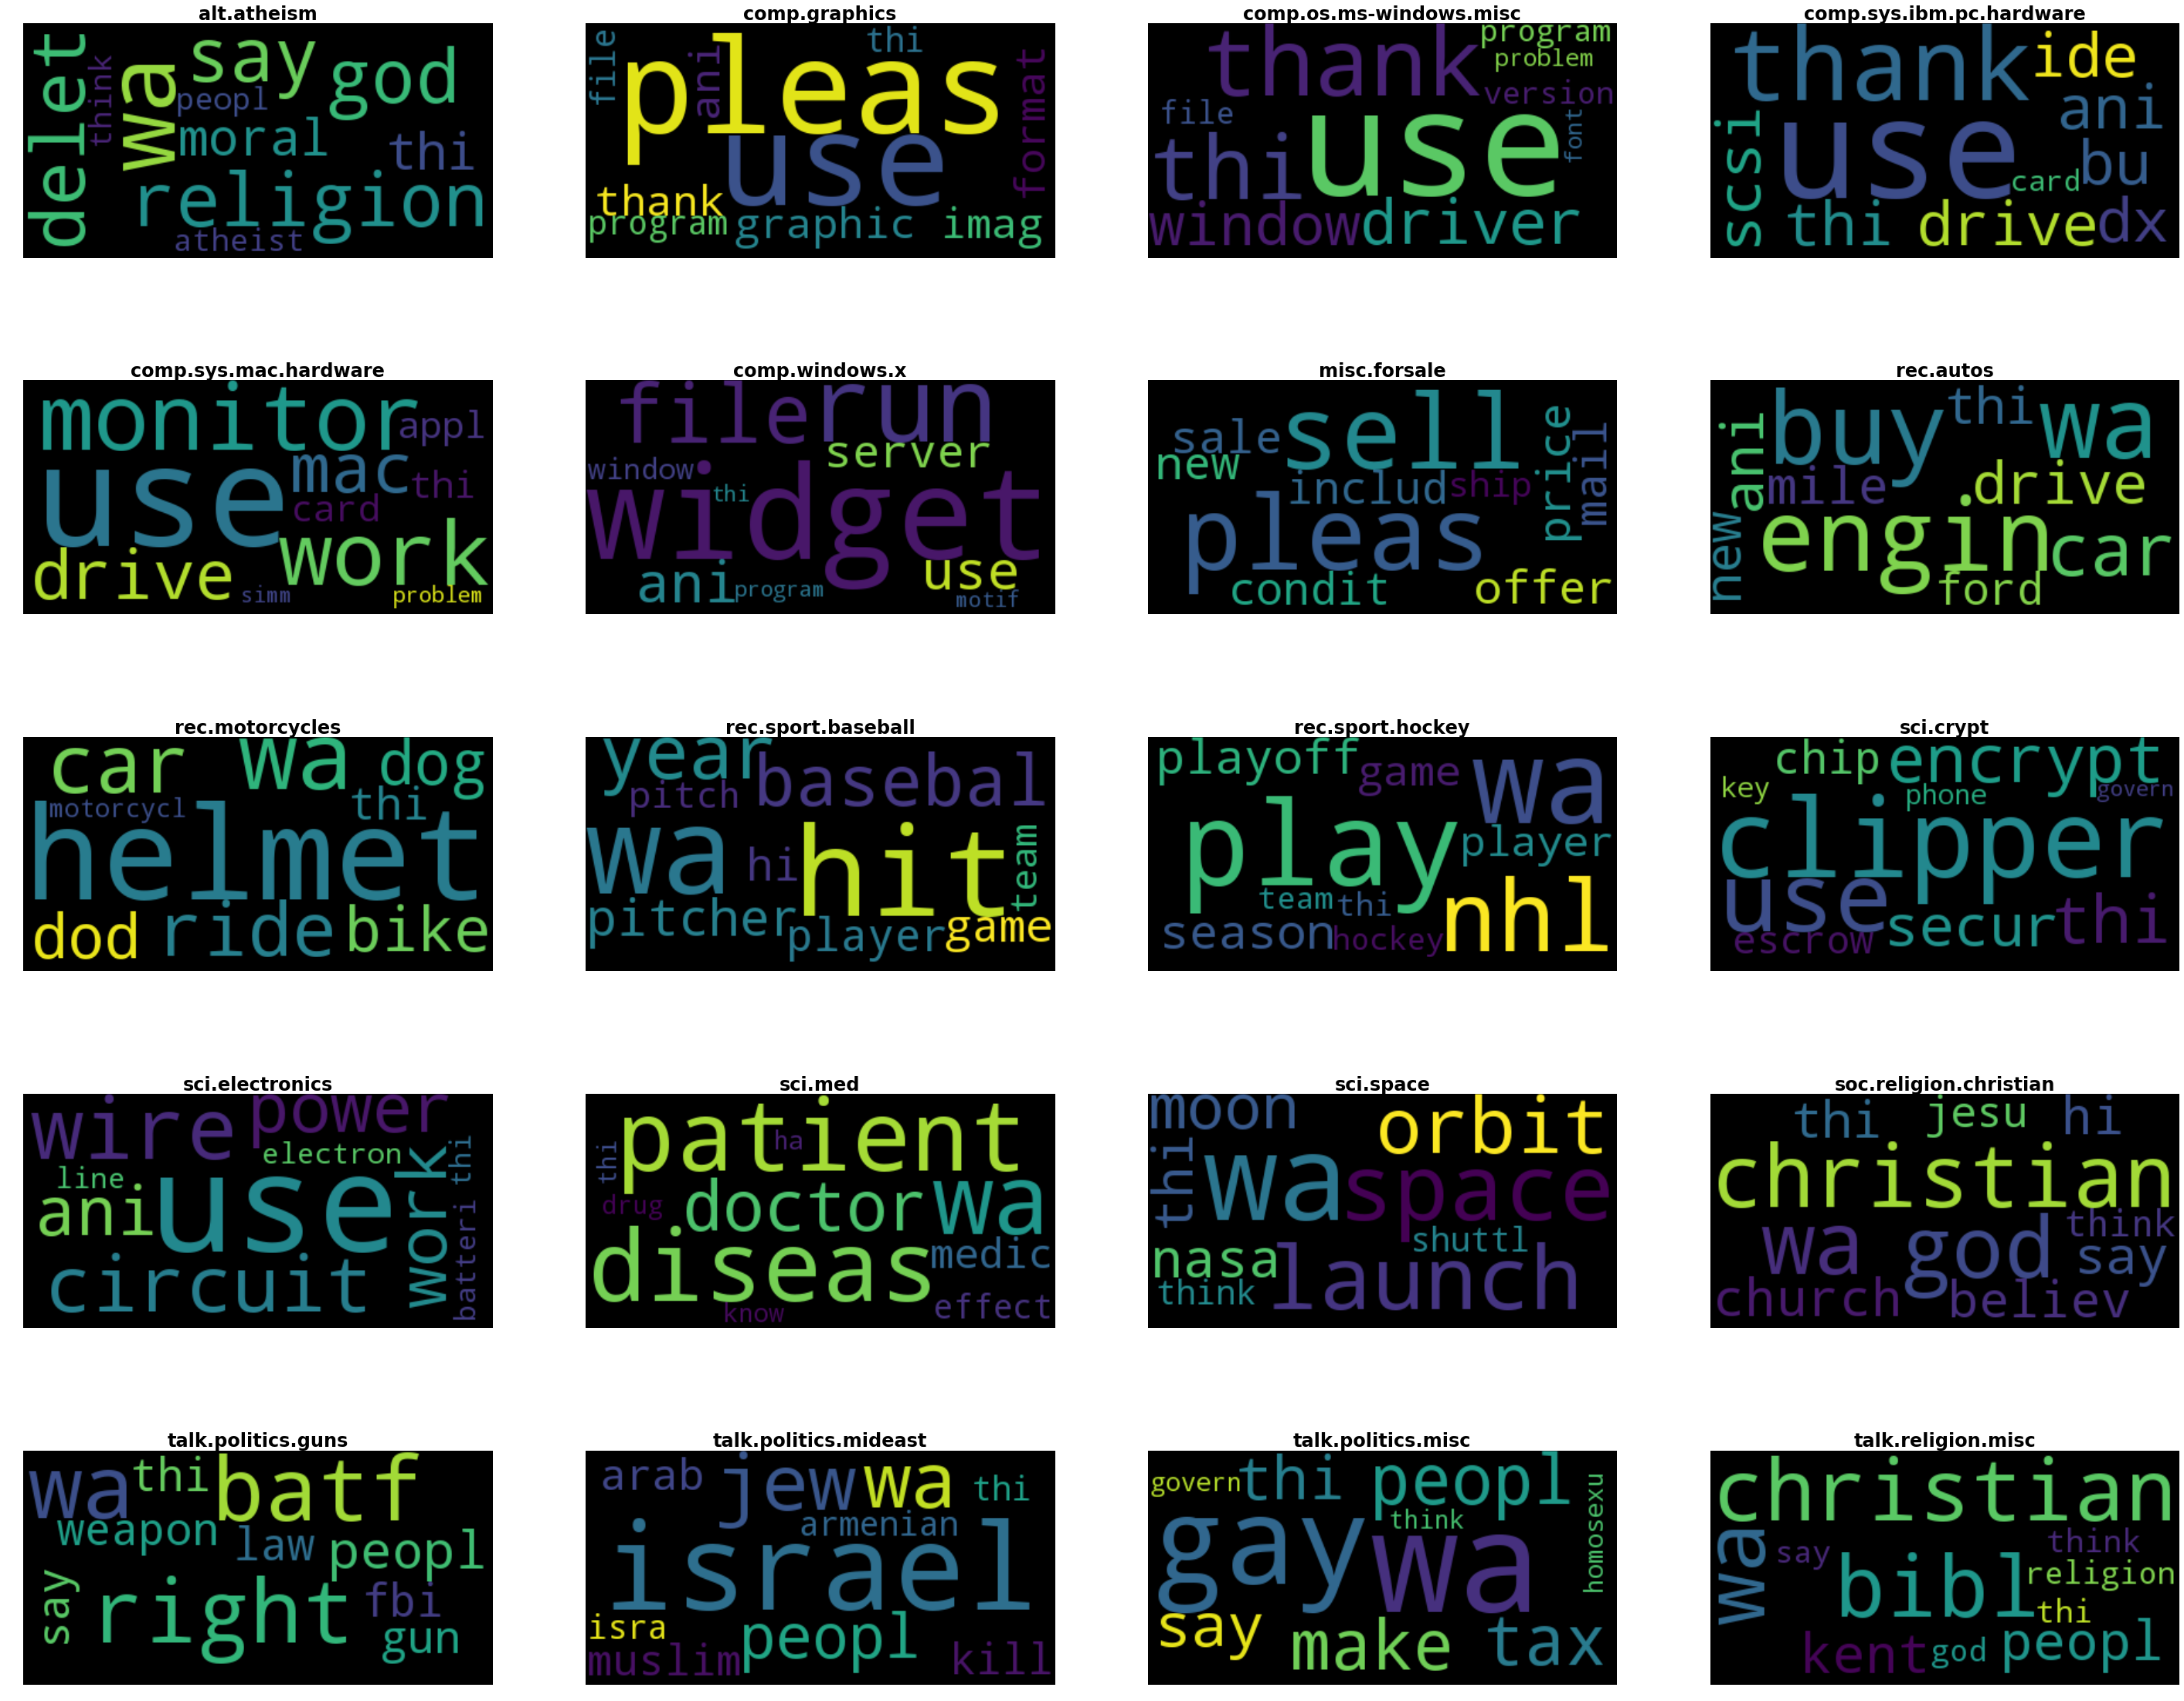

In [32]:
show_topK(em_nb_clf, vectorizer, category_names, K=10) # keywords for each class by semisupervised EM NB classifier